![title](images/header.png)

# Ve - Supervised Classification with CAFI data - multiple models
-------
This notebook performed a supervised classification of eSBAE points based on the validated data from systematic points (2015-2022) for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
The models are then combined to assign categories of change to all systematic points
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [ ]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler

In [ ]:
#pip install MiniSom

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


# 1 - data preparation

## 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 6a - with all the eSBAE columns

In [2]:
ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,cnc_1520,CAFI_LC_2015,chg_prob,simple_combined,kmeans,plotid,lon,lat,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year,Ref_NFType,Ref_FType,Commentaires,collection,interpreted,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,stratum
0,67,45,2020.137,1387.517090,1.123945,2017.288,0.010786,7937.461481,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,24.384312,61.561971,214.932292,-174.438721,0.0,0.0,196.0,1.0,73.0,7.0,22.0,54.0,35.252872,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,90.0,30.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.169508345861827 -2.39305080249901),76451,NaN,1,0.060000,0.060000,1,76451,10.169508,-2.393051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,70,42,2018.340,948.520996,2.265196,2016.348,0.437613,5604.878571,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,98.151968,25.593738,183.914615,11.354581,0.0,0.0,9.0,1.0,77.0,65.0,2.0,72.0,44.703648,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,90.0,37.0,31.0,11.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.17450939802276 -2.383416062692006),76452,NaN,1,0.019333,0.019333,1,76452,10.174509,-2.383416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,113,73,-1.000,0.000000,0.000000,2016.458,0.401874,8892.777626,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,39.203991,25.853591,121.616387,-55.887372,0.0,0.0,129.0,1.0,76.0,15.0,10.0,70.0,9.088154,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,74.0,21.0,16.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.173277074274033 -2.903386999146695),90643,NaN,13,0.215333,0.215333,2,90643,10.173277,-2.903387,90643.0,gmbombonda@gmail.com,False,2023-06-23 12:24,128.9 secs,POINT(10.173277 -2.903387),1.0,NaN,0.0,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,C,2.0,1,Stable,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [3]:
len(ceo_esbae_1522)

222878

In [4]:
ceo_esbae_1522['Ref_Change_1522'].value_counts(dropna=False)

Ref_Change_1522
NaN    217577
0.0      5070
1.0       231
Name: count, dtype: int64

In [6]:
#testing inclusion of phase I data - enter ISO to select country
#ceo_esbae_1520 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_merge.csv', delimiter=',')
#ceo_esbae_1520 = ceo_esbae_1520[ceo_esbae_1520['ISO'] == 'GAB']
#ceo_esbae_1520.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Change_Type_1520,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year_1520,Ref_Change_1520,collection,interpreted,Def2016,Def2017,Def2018,Def2019,Def2020,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Defall,Degall,Stable,NF
4,POINT (8.741194 -0.675759),9023,66,37,2020.551,-612.401123,-0.689755,2019.762,0.356480,13092.747748,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,9461.756757,1273.425737,5146.0,10000.0,-164.674283,162.635953,346.338651,-577.550151,2020.551,-4433.883959,102.0,1.0,63.0,3.0,16.0,39.0,1.740432,95.0,95.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,NaN,77.0,9.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,12.0,9022,256821,8442,8.741192,-0.675758,GAB,14,0,14,NF,NaN,0,0,0,0,0,0,0,0,0,0,ceo,NF,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,POINT (8.985891 -1.139287),2398,46,31,2016.455,29.464001,-0.683219,2020.397,0.263831,3881.167742,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,9734.444624,488.474901,7846.5,10000.0,88.743399,65.433544,257.875765,-84.601842,0.000,0.000000,85.0,1.0,66.0,14.0,14.0,53.0,2.316049,95.0,95.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,71.0,14.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,12.0,2397,60171,2035,8.985893,-1.139288,GAB,14,0,14,NF,NaN,0,0,0,0,0,0,0,0,0,0,ceo,NF,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10,POINT (8.966757 -1.071647),7247,55,32,2017.679,371.139679,1.009140,2019.608,-0.000000,4361.716146,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,9832.716146,785.916389,5471.0,10000.0,-143.803901,113.708689,24.734607,-395.987981,0.000,0.000000,226.0,1.0,73.0,15.0,23.0,51.0,16.687479,95.0,95.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,83.0,20.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,12.0,7246,203255,6735,8.966759,-1.071645,GAB,7,1,7,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,POINT (8.963257 -1.084043),7621,50,29,2016.389,1836.200684,2.682255,2019.762,0.351634,3412.212644,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,9804.942529,392.083811,8291.5,10000.0,-111.231997,57.203314,76.627752,-242.612585,0.000,0.000000,255.0,1.0,68.0,23.0,11.0,58.0,2.521187,95.0,95.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,74.0

In [7]:
#ceo_esbae_1520['Ref_Change_Year_1520'].value_counts()

Ref_Change_Year_1520
Stable     809
NF         252
Def2017     12
Deg2017     12
Def2018     11
Deg2018      7
Def2016      7
Deg2016      4
Def2020      4
Def2019      3
Deg2019      2
Deg2020      1
Name: count, dtype: int64

In [8]:
#ceo_esbae_1520['Ref_Change_Type_1520'].value_counts()

Ref_Change_Type_1520
Stable    809
NF        252
Def        37
Deg        26
Name: count, dtype: int64

In [9]:
#ceo_esbae_1520['Ref_Change_1520'].value_counts()

Ref_Change_1520
0    1061
1      63
Name: count, dtype: int64

In [10]:
#ceo_esbae_1520['interpreted'] = 1

In [11]:
#len(ceo_esbae_1520)

1124

In [12]:
#all_ceo_esbae = pd.concat([ceo_esbae_1522, ceo_esbae_1520], ignore_index=True)
#all_ceo_esbae.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,cnc_1520,CAFI_LC_2015,chg_prob,simple_combined,kmeans,plotid,lon,lat,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year,Ref_NFType,Ref_FType,Commentaires,collection,interpreted,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,stratum,UniqueID,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_LCtype,Ref_Change_Type_1520,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year_1520,Ref_Change_1520
0,67,45,2020.137,1387.517090,1.123945,2017.288,0.010786,7937.461481,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,9044.740370,1071.310772,4640.0,10000.0,24.384312,61.561971,214.932292,-174.438721,0.0,0.0,196.0,1.0,73.0,7.0,22.0,54.0,35.252872,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,90.0,30.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.169508345861827 -2.39305080249901),76451.0,NaN,1.0,0.060000,0.060000,1.0,76451.0,10.169508,-2.393051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70,42,2018.340,948.520996,2.265196,2016.348,0.437613,5604.878571,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,9484.973810,442.238111,8407.0,10000.0,98.151968,25.593738,183.914615,11.354581,0.0,0.0,9.0,1.0,77.0,65.0,2.0,72.0,44.703648,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,90.0,37.0,31.0,11.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,POINT (10.17450939802276 -2.383416062692006),76452.0,NaN,1.0,0.019333,0.019333,1.0,76452.0,10.174509,-2.383416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,113,73,-1.000,0.000000,0.000000,2016.458,0.401874,8892.777626,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,9165.134247,560.100610,7408.0,9952.0,39.203991,25.853591,121.616387,-55.887372,0.0,0.0,129.0,1.0,76.0,15.0,10.0,70.0,9.088154,10.0,10

In [13]:
#combine change column when using all ceo data
#all_ceo_esbae['Ref_Change'] = np.where((all_ceo_esbae['Ref_Change_1522'] == 1) | (all_ceo_esbae['Ref_Change_1520'] == 1), 1, 0)
#all_ceo_esbae['Ref_Change'].value_counts(dropna=False)

Ref_Change
0    223708
1       294
Name: count, dtype: int64

In [14]:
#combine ref change year
# Fill NaN values in 'Ref_Change_1522' with values from the Ref_Change_1520
#all_ceo_esbae['Ref_Change_Ceo_Merge'] = all_ceo_esbae['Ref_Change_Year_1522'].fillna(all_ceo_esbae['Ref_Change_Year_1520'])
#all_ceo_esbae['Ref_Change_Ceo_Merge'].value_counts(dropna=False)

Ref_Change_Ceo_Merge
NaN        216339
Stable       5879
NF           1490
Deg2022        38
Deg2018        32
Deg2020        29
Def2016        28
Deg2017        27
Deg2021        26
Def2017        25
Deg2016        18
Deg2019        18
Def2018        18
Def2022        13
Def2020        10
Def2021         7
Def2019         5
Name: count, dtype: int64

In [15]:
#combine ref change year
# Fill NaN values in 'Ref_Change_1522' with values from the Ref_Change_1520
#all_ceo_esbae['Ref_Change_Type_Ceo_Merge'] = all_ceo_esbae['Ref_Change_Type_1522'].fillna(all_ceo_esbae['Ref_Change_Type_1520'])
#all_ceo_esbae['Ref_Change_Type_Ceo_Merge'].value_counts(dropna=False)

Ref_Change_Type_Ceo_Merge
NaN       216339
Stable      5879
NF          1490
Deg          188
Def          106
Name: count, dtype: int64

In [16]:
#len(all_ceo_esbae)

224002

In [17]:
#all_ceo_esbae['Defall'].value_counts(dropna=False)

Defall
NaN    216339
0.0      7557
1.0       106
Name: count, dtype: int64

In [18]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 
       'gfc_tc00','CAFI_LC_2015',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub']

In [19]:
# choose which data set to use
# all ceo data from both phases
#df = all_ceo_esbae
# only systematic ceo data
df = ceo_esbae_1522

In [21]:
all_ceo_cols = df.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope'

### 1.2 where/what are NAs

In [22]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 8, 'dw_class_mode': 363, 'dw_tree_prob__max': 363, 'dw_tree_prob__min': 363, 'dw_tree_prob__stdDev': 363, 'dw_tree_prob_mean': 363, 'elevation': 8, 'esa_lc20': 8, 'esa_lc21': 8, 'esri_lc17': 8, 'esri_

In [23]:
# Specify the columns to replace NaN with 0
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 'potapov_tree_height','elevation','slope', 'tmf_2016', 
                   'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)


In [24]:
# Specify the columns you want to impute with the mean value
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [25]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_prob__min': 0, 'dw_tree_prob__stdDev': 0, 'dw_tree_prob_mean': 0, 'elevation': 0, 'esa_lc20': 0, 'esa_lc21': 0, 'esri_lc17': 0, 'esri_lc18': 0, 

In [26]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    216339
1.0      5879
0.0      1784
Name: count, dtype: int64

In [27]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

### 1.3 Run classification

#### 4 individual models

In [28]:
# predictors used change/nochange classification
gdf['def_prob'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.8079081299752056


array([<Axes: title={'center': 'def_prob'}>], dtype=object)

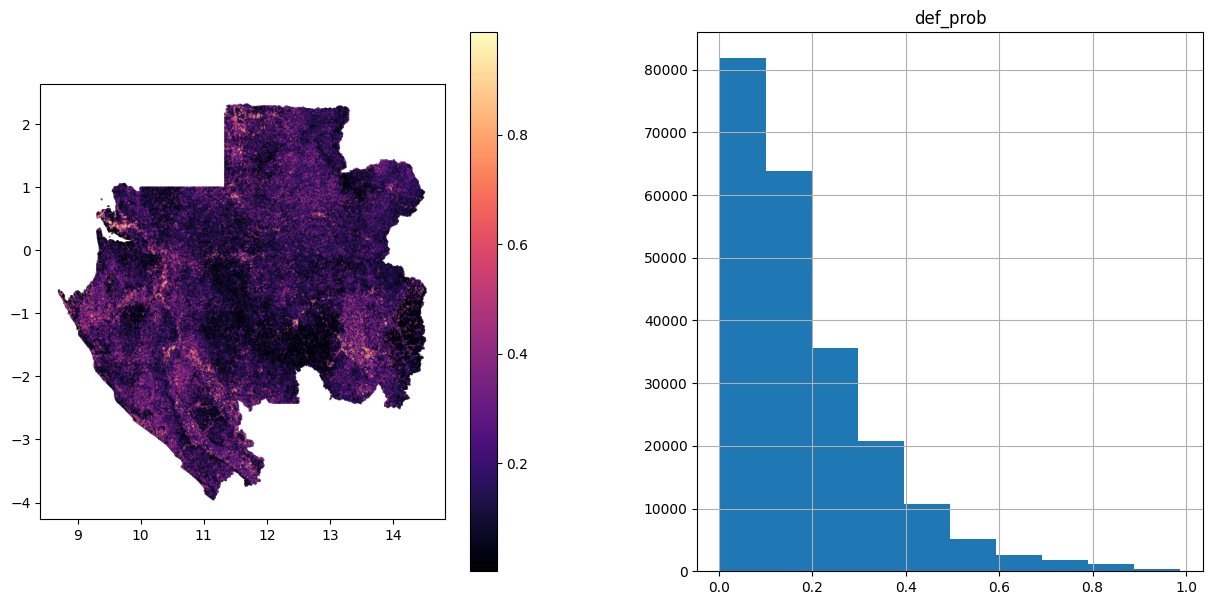

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob', ax=ax[1])

In [30]:
# predictors used change/nochange classification
gdf['deg_prob'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.8041237113402062


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob', ax=ax[1])

In [ ]:
# predictors used change/nochange classification
gdf['stable_prob'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob', ax=ax[1])

In [ ]:
# predictors used change/nochange classification
gdf['nf_prob'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob', ax=ax[1])

In [ ]:
interpreted = gdf[gdf['interpreted'] == 1]

In [ ]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted[interpreted['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

In [ ]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted[interpreted['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

In [ ]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted[interpreted['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

In [ ]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted[interpreted['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### decision tree to assign values to categories from models

In [ ]:
threshold = 0.8

In [ ]:
gdf['sim_def'] = (gdf['def_prob'] > threshold).astype(int)
gdf['sim_deg'] = (gdf['deg_prob'] > threshold).astype(int)
gdf['sim_stable'] = (gdf['stable_prob'] > threshold).astype(int)
gdf['sim_nf'] = (gdf['nf_prob'] > threshold).astype(int)

In [ ]:
# Define a function to check conditions and return the corresponding label
# check the order of the decisions which has an effect on the result
# in this case the decisions are in order or area stable > deg > def
def classify(row):
    if row['sim_stable'] >= 1:
        return 'stable'
    elif row['sim_deg'] >= 1:
        return 'deg'
    elif row['sim_def'] >= 1:
        return 'def'
    else:
        return 'nf'

# Apply the function to create a new 'classification' column
gdf['classification'] = gdf.apply(classify, axis=1)

# Display the DataFrame with the new column
gdf['classification'].value_counts(dropna=False)

In [ ]:
study_area = 26287600
# Calculate the proportions
class_counts = gdf['classification'].value_counts()
percentage = (class_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': class_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

In [ ]:
interpreted = gdf[gdf['interpreted'] == 1]

In [ ]:
# Group by the selected columns and count occurrences
result_df = interpreted.groupby(['classification', 'Defall', 'Degall', 'Stable', 'NF']).size().reset_index(name='count')

# Display the result
print(result_df)

In [ ]:
category_colors = {
    'def': 'red',
    'deg': 'orange',
    'stable': 'green',
    'nf': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['classification'].map(category_colors), s=4)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Decision Tree')
plt.grid()
plt.show()

In [ ]:
# Create a new column 'Count' based on the conditions
gdf['Count'] = gdf[['sim_def', 'sim_deg', 'sim_stable', 'sim_nf']].sum(axis=1)

# Display the cross-tabulated counts
cross_tab = pd.crosstab(index=gdf['Count'], columns="Count")
print(cross_tab)

#### add years from cusum date

In [ ]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

In [ ]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)

In [ ]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [ ]:
def y(x):
  if x['classification'] == 'def' and x['cusum_change_year'] == 2016: return 'Def2016'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2017: return 'Def2017'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2018: return 'Def2018'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2019: return 'Def2019'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2020: return 'Def2020'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2021: return 'Def2021'
  elif x['classification'] == 'def' and x['cusum_change_year'] == 2022: return 'Def2022'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2016: return 'Deg2016'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2017: return 'Deg2017'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2018: return 'Deg2018'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2019: return 'Deg2019'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2020: return 'Deg2020'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2021: return 'Deg2021'
  elif x['classification'] == 'deg' and x['cusum_change_year'] == 2022: return 'Deg2022'
  elif x['classification'] == 'nf' : return 'NF'
  elif x['classification'] == 'stable' : return 'Stable'
  else: return ''

gdf['Sim_Ref_Change_Year_1522'] = gdf.apply(y, axis=1)

annual_counts = gdf['Sim_Ref_Change_Year_1522'].value_counts()
annual_counts = annual_counts.sort_index()
print(annual_counts)

In [ ]:
#create hybrid column with values from interpreted data, and modeled for all the rest
gdf['Sim_CEO_Ref_Change_Year_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Year_1522'], gdf['Sim_Ref_Change_Year_1522'])
gdf['Sim_CEO_Ref_Change_Type_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Type_1522'], gdf['classification'])

In [ ]:
gdf['Sim_CEO_Ref_Change_Type_1522'].value_counts(dropna=False)

In [ ]:
gdf['Sim_CEO_Ref_Change_Year_1522'].value_counts(dropna=False)

#### plot data

In [ ]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

In [ ]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [ ]:
#export
out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv'
gdf.to_csv(out_file,index=True)

#### unbalanced RF - ***work in progress ignore for now***

In [ ]:
# Assuming X contains your attribute columns and y contains your target labels
X = interpreted[eSBAE_cols]
y = interpreted['Ref_Change_Type_Ceo_Merge']

In [ ]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in X.columns:
    missing_counts[column] = X[column].isna().sum()

# Print the counts
print(missing_counts)

In [ ]:
unique_labels = np.unique(y)
unique_labels = y.value_counts().index
# Specify the unique labels in your target variable as classes
unique_labels = np.unique(y)  # Or use the appropriate method based on your data
unique_labels

In [ ]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y), y=y_train)
class_weights
# Create a dictionary to map class labels to their respective class weights
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

In [ ]:
# Create an instance of the classifier
clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42, oob_score=True,class_weight=class_weight_dict)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Make predictions on new data
gdf['balRF_pred'] = clf.predict(gdf[eSBAE_cols])

y_pred = clf.predict(X_test)

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

In [ ]:
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['balRF_pred'].map(category_colors), s=5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest Classification')
plt.grid()
plt.show()

In [ ]:
#get accuracies with replacement

In [ ]:
study_area = 26287600
# Calculate the proportions
value_counts = esbae_ceo['balRF_pred'].value_counts()
percentage = (value_counts / len(esbae_ceo)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)